# i. Perkenalan

Nama : Abraham Rashid Haikal

Batch : HCK 18

Objective :Membuat Model ANN untuk prediksi gambar orang yang menggunakan helm atau tidak dan melakukan improvement terhadap model dasar dengan menggunakan metode yang tepat.

# ii. Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
import plotly_express as px
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# iii. Data Loading
Data diproses dari folder raw ke dataframe

In [2]:
# Mengganti nama gambar helm
helm_files = glob.glob(r'C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hck-g7-new-abehaikal\GearedorNot\Wearing Safety Gear\*')
num = 1
for cf in helm_files:
  os.rename(cf, r'C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hck-g7-new-abehaikal\GearedorNot\Wearing Safety Gear\helm_' + "{:03d}".format(num) + '.jpg')
  num += 1

In [3]:
# Mengganti nama gambar tanpa helm
no_helm_files = glob.glob(r'C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hck-g7-new-abehaikal\GearedorNot\Not Wearing Safety Gear\*')
num = 1
for cf in no_helm_files:
  os.rename(cf, r'C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hck-g7-new-abehaikal\GearedorNot\Not Wearing Safety Gear\no_helm_' + "{:03d}".format(num) + '.jpg')
  num += 1

In [2]:
# Menyatakan variabel untuk file helm dan tanpa helm
helm_files = glob.glob(r'C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hck-g7-new-abehaikal\GearedorNot\Wearing Safety Gear\*')
no_helm_files = glob.glob(r'C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hck-g7-new-abehaikal\GearedorNot\Not Wearing Safety Gear\*')

In [3]:
all_files = helm_files + no_helm_files # Menggabungkan file helm dan tanpa helm
labels = ['helm' for i in range(len(helm_files))] + ['no_helm' for i in range(len(no_helm_files))] # Menyatakan label untuk dataframe
img_df = pd.DataFrame({'images':all_files, 'label':labels}) # Membuat dataframe
img_df = img_df.sample(len(img_df)).reset_index(drop=True) 
img_df

,images,label
0,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,helm
1,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,no_helm
2,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,no_helm
3,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,helm
4,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,helm
...,...,...
347,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,no_helm
348,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,no_helm
349,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,no_helm
350,C:\Users\haika\latihan\GC\Phase2\p2-ftds018-hc...,no_helm


In [4]:
# Menyimpan dataframe untuk deployment
img_df.to_csv('img_df.csv')

# iv. EDA

## 1. Menampilkan Gambar

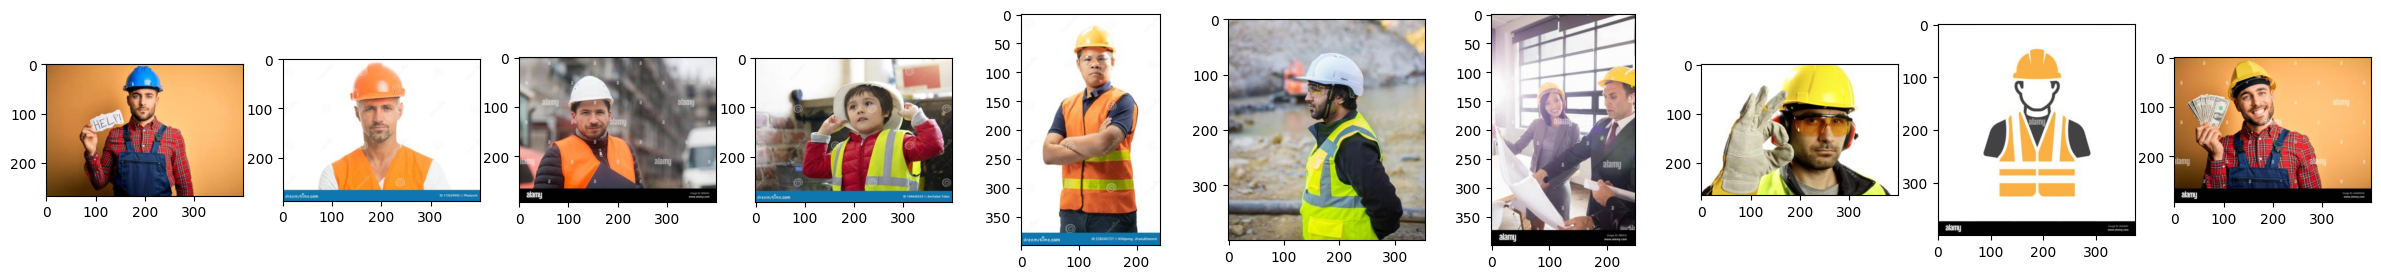

In [6]:
# Menampilkan gambar helm

fig, ax = plt.subplots(ncols=10, figsize=(30,3))
for i in range(10):
  helm = plt.imread(helm_files[i])
  ax[i].imshow(helm)

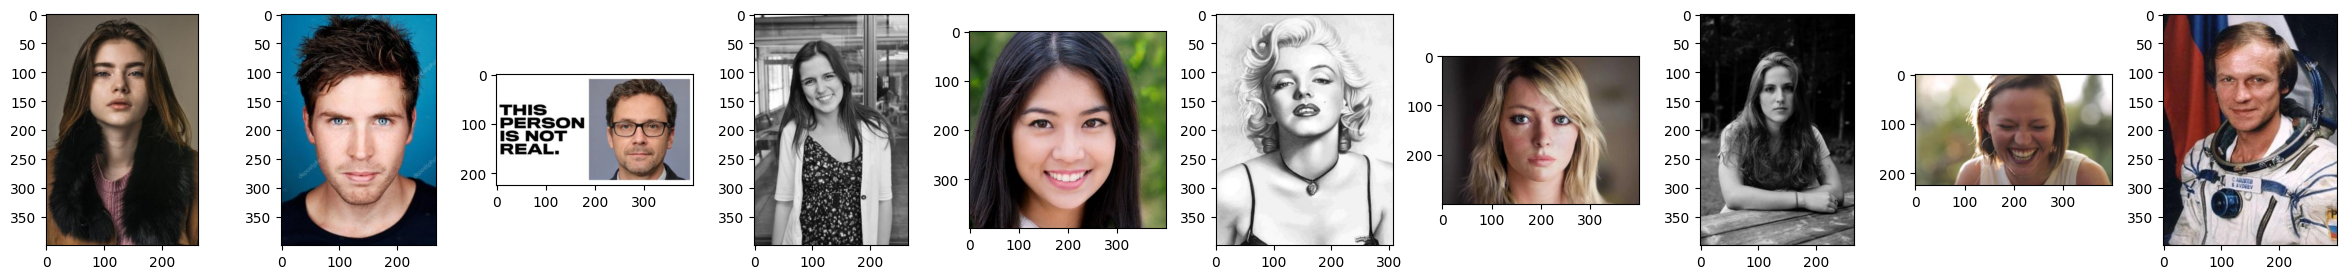

In [7]:
# Menampilkan gambar tanpa helm

fig, ax = plt.subplots(ncols=10, figsize=(30,3))
for i in range(10):
  no_helm = plt.imread(no_helm_files[i])
  ax[i].imshow(no_helm)

## 2. Distribusi Data

In [8]:
df_value_counts = img_df['label'].value_counts().sort_index()

# Create the bar chart using plotly express
fig = px.bar(df_value_counts, 
             x=df_value_counts.index,  # Set index as x-axis
             y=df_value_counts.values,  # Set values as y-axis
             text_auto= True,
             title="Distribusi Data")
fig.update_layout(yaxis_tickformat='', yaxis_showticklabels=False)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})

Dataframe terdiri dari 193 gambar orang tanpa helm dan 159 gambar orang dengan helm. Selisih yang kecil antara dua label tersebut menunjukkan bahwa data terbilang cukup seimbang.

# v. Feature Engineering

## 1. Split Data

### Train, Validation, & Test Set

In [9]:
trainfull_df, test_df= train_test_split(img_df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(trainfull_df, test_size=0.15, random_state=42)

print('Train Size : ', train_df.shape)
print('Val Size   : ', val_df.shape)
print('Test Size  : ', test_df.shape)

Train Size :  (254, 2)
Val Size   :  (45, 2)
Test Size  :  (53, 2)


## 2. Augmentasi Data
Untuk Menambah variasi data, train set diaugmentasi dengan horizontal dan vertical flip serta rotasi gambar dan sekaligus melakukan rescaling. Train set hanya melalui proses rescale karena tidak boleh diaugmentasi karena test set adalah representasi data asli.

Found 254 validated image filenames belonging to 2 classes.
Found 45 validated image filenames belonging to 2 classes.


Found 53 validated image filenames belonging to 2 classes.


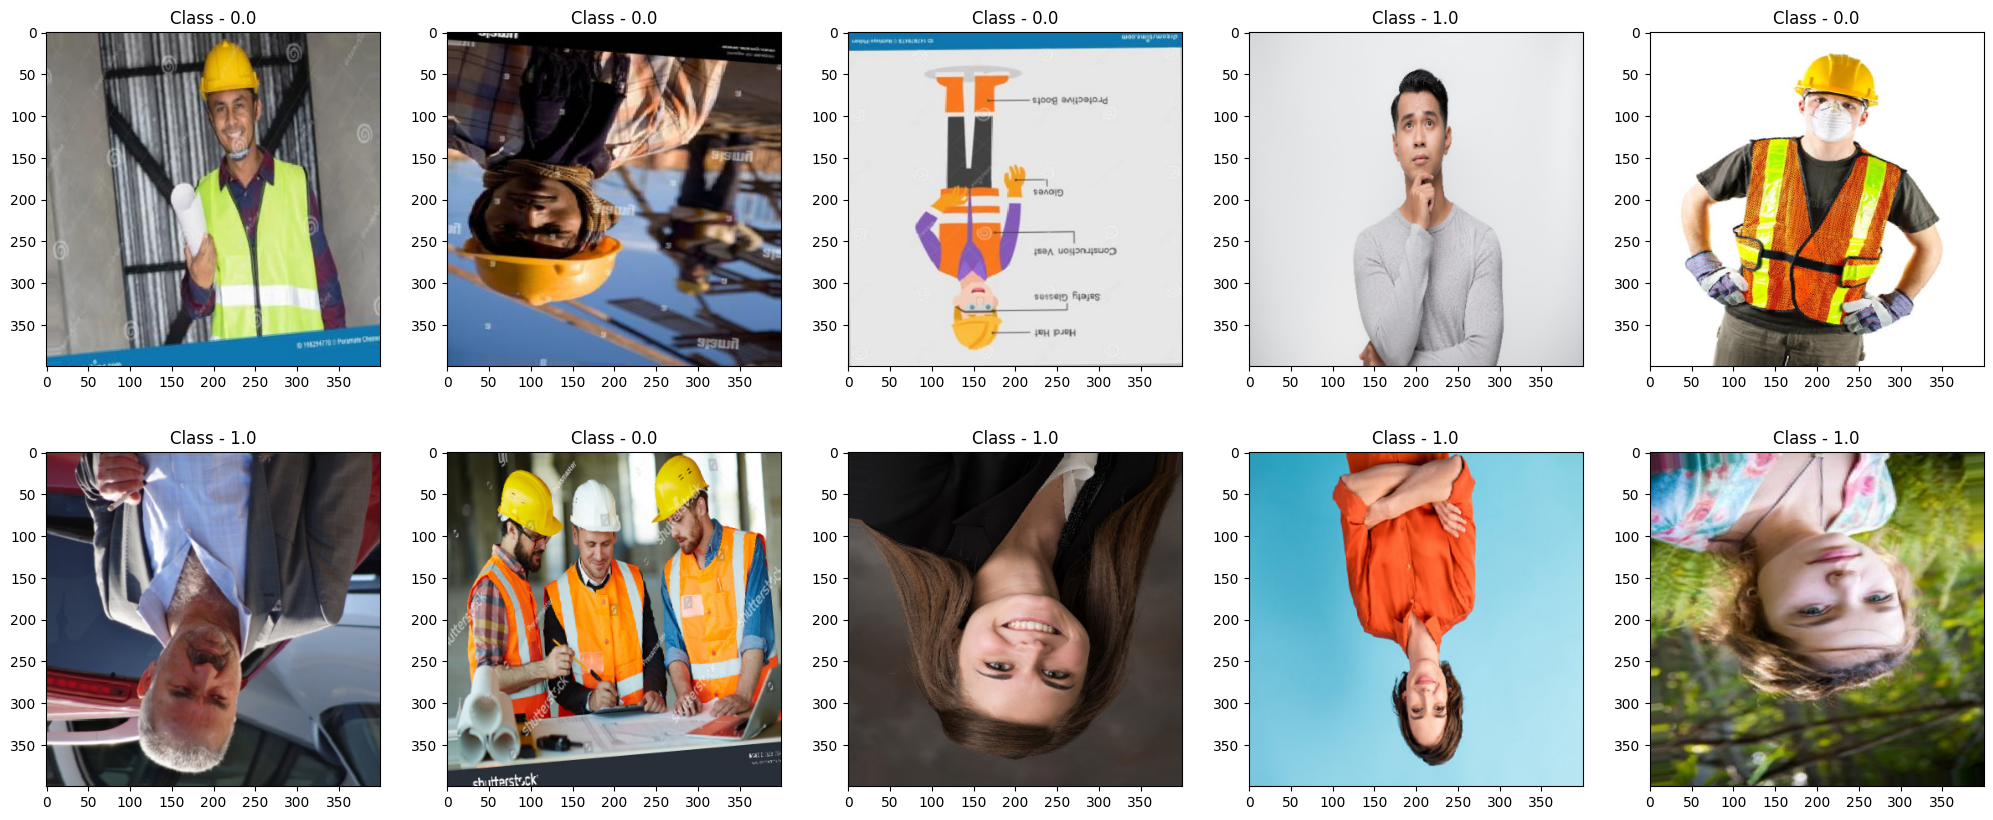

In [10]:
# Mendefinisikan image generator untuk train dan val set
imgen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,         # Rescale gambar
    horizontal_flip=True,   # Horizontal flip
    vertical_flip=True,     # Vertical flip
    rotation_range=10       # Rotasi
)

# Mendefinisikan image generator untuk test set
test_datagen = ImageDataGenerator(rescale=1./255)

# Menerapkan image generator ke train, val, dan test set
train = imgen.flow_from_dataframe(
    train_df,
    x_col='images',
    y_col='label',
    target_size=(400, 400),
    class_mode='binary',
    shuffle=True,
    seed=2
)

val = imgen.flow_from_dataframe(
    val_df,
    x_col='images',
    y_col='label',
    target_size=(400, 400),
    class_mode='binary',
    shuffle=False,
    seed=2
)

test = test_datagen.flow_from_dataframe(
    test_df,
    x_col='images',
    y_col='label',
    target_size=(400, 400),
    class_mode='binary',
    shuffle=False,
    seed=2)

# Menampilkan gambar train set
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))
n = 0

for i in range(2):
    for j in range(5):
        img = train[0][0][n] * 255  # Rescale back for visualization
        img = img.astype('uint8')
        ax[i][j].imshow(img)
        ax[i][j].set_title('Class - ' + str(train[0][1][n]))
        n += 1

plt.show()

In [11]:
# Menampilkan indeks kelas
train.class_indices

{'helm': 0, 'no_helm': 1}

# vi. ANN Training

## 1. Definisi Model

In [12]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 5, restore_best_weights=True)
]

In [13]:
inputs= [400,400,3]

seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

#arsitektur model sequential
model_adam= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_adam.add(Conv2D(filters=16, kernel_size=3, activation='relu',
                    input_shape=inputs))
model_adam.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_adam.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
model_adam.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 3
model_adam.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model_adam.add(MaxPooling2D(pool_size= 2, strides=2))

model_adam.add(Flatten())
model_adam.add(Dense(units=128, activation='relu'))
model_adam.add(Dense(units=1,activation='sigmoid'))

model_adam.summary()

model_adam.compile(optimizer='Adam', loss='binary_crossentropy', metrics= ['accuracy'])

c:\Users\haika\anaconda3\envs\phaseone\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,898,209 (72.09 MB)

 Trainable params: 18,898,209 (72.09 MB)

 Non-trainable params: 0 (0.00 B)

Model yang digunakan adalah model sequential dengan 3 layer konvolusi yang diikuti setiap konvolusinya dengan MaxPooling. Kemudian 1 layer flatten dan 1 layer dense, semua dengan activation relu dan terakhir layer output dengan activation sigmoid karena outputnya adalah binary classification.

## 2. Model Training

In [14]:
history= model_adam.fit(train,
                           epochs= 20, validation_data= val,
                           callbacks= callbacks1)

Epoch 1/20


c:\Users\haika\anaconda3\envs\phaseone\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4842 - loss: 2.4120 - val_accuracy: 0.5778 - val_loss: 0.7254
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5774 - loss: 0.6830 - val_accuracy: 0.4889 - val_loss: 0.7158
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 922ms/step - accuracy: 0.6542 - loss: 0.6128 - val_accuracy: 0.8000 - val_loss: 0.5961
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 919ms/step - accuracy: 0.7956 - loss: 0.4693 - val_accuracy: 0.7778 - val_loss: 0.7788
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 923ms/step - accuracy: 0.8532 - loss: 0.3556 - val_accuracy: 0.8222 - val_loss: 0.7036
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 928ms/step - accuracy: 0.8714 - loss: 0.3489 - val_accuracy: 0.7778 - val_loss: 0.7823
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 943ms/step - accuracy: 0.8890 - loss: 0.2854 - val_accuracy: 0.8667 - val_loss: 0.6667
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 911ms/step - accuracy: 0.9213 - loss: 0.2290 - val_accuracy: 0.7778 - val_loss: 0.8246


## 3. Evaluasi Model

In [15]:
import seaborn as sns

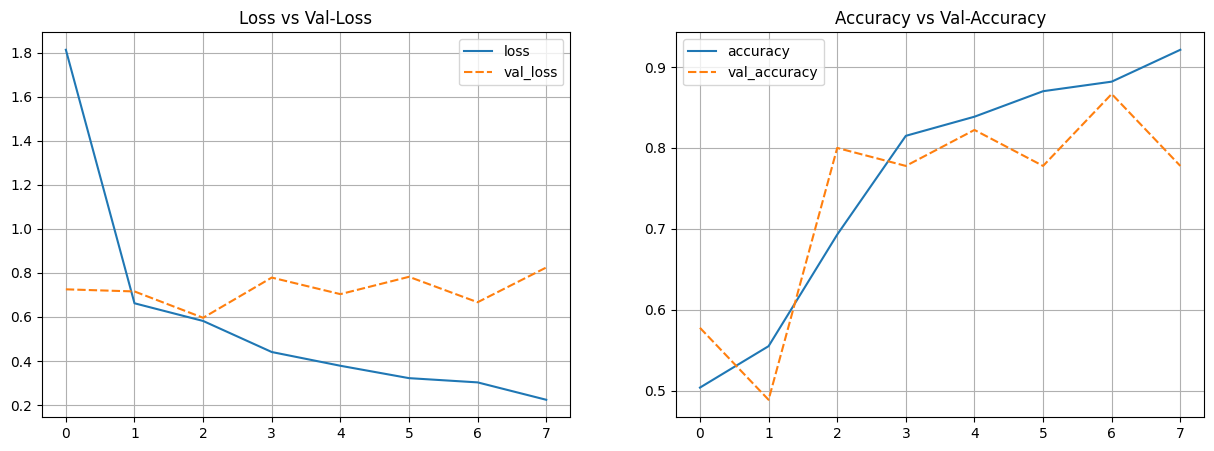

In [16]:
# Plot Training Results

history_seq_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_seq_df[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_seq_df[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Berdasarkan plot loss dari train dan val set, ditemukan bahwa train dan val set masih belum menemui keseimbangan. Dari plot accuracy dari train dan val set, ditemukan bahwa validation set masih belum mampu mengimbangi train set dalam hal akurasi prediksi gambar. Hal ini menunjukkan terjadinya fenomena exploding gradient. Hal ini dapat diatasi dengan menambahkan weight initializer, L2 dan dropout ke model yang akan dicoba untuk model improvement.

In [17]:
from sklearn.metrics import classification_report

In [18]:
test_results = model_adam.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

c:\Users\haika\anaconda3\envs\phaseone\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Test Loss     : 0.6767
Test Accuracy : 0.7736


Model yang dibuat memiliki nilai akurasi sebesa 84% dengan loss sebesar 0.49.

# vii. ANN Improvement

## 1. Definisi Model

In [19]:
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Arsitektur model sequential
model_imp = Sequential()

# Layer Conv 1, adding L2 regularization
model_imp.add(Conv2D(filters=16, kernel_size=3, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed),
                      kernel_regularizer=l2(0.0001),  # Adding L2 regularization
                      input_shape=inputs))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Layer Conv 2, adding L2 regularization
model_imp.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed),
                      kernel_regularizer=l2(0.0001)))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))

# Layer Conv 3, adding L2 regularization
model_imp.add(Conv2D(filters=64, kernel_size=3, activation='relu',
                         kernel_initializer=tf.keras.initializers.HeNormal(seed),
                      kernel_regularizer=l2(0.0001)))
model_imp.add(MaxPooling2D(pool_size=2, strides=2))


# Flatten the output
model_imp.add(Flatten())

# Fully connected layer with L2 regularization and Dropout
model_imp.add(Dense(units=128, activation='relu',
                        kernel_initializer=tf.keras.initializers.HeNormal(seed),
                     kernel_regularizer=l2(0.0001)))  # Adding L2 regularization
model_imp.add(Dropout(0.001))  # Adding Dropout with a rate of 0.1

# Output layer
model_imp.add(Dense(units=1, activation='sigmoid',
                        kernel_initializer=tf.keras.initializers.GlorotNormal(seed)))

# Display the model architecture
model_imp.summary()

# Compile the model
model_imp.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\haika\anaconda3\envs\phaseone\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,898,209 (72.09 MB)

 Trainable params: 18,898,209 (72.09 MB)

 Non-trainable params: 0 (0.00 B)

Model improvement dilakukan dengan menambahkan weight initializer  He untuk activation reLU dan Glorot untuk sigmoid.

## 2. Model Training

In [20]:
# Train the model
history1 = model_imp.fit(train,
                         epochs=20, validation_data=val)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4891 - loss: 22.0015 - val_accuracy: 0.5778 - val_loss: 1.9298
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 955ms/step - accuracy: 0.5135 - loss: 1.3512 - val_accuracy: 0.4222 - val_loss: 0.8158
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 958ms/step - accuracy: 0.4647 - loss: 0.7998 - val_accuracy: 0.6667 - val_loss: 0.7392
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 946ms/step - accuracy: 0.7295 - loss: 0.7309 - val_accuracy: 0.7778 - val_loss: 0.7135
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 942ms/step - accuracy: 0.7499 - loss: 0.6771 - val_accuracy: 0.8000 - val_loss: 0.6788
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 951ms/step - accuracy: 0.7561 - loss: 0.6459 - val_accuracy: 0.8000 - val_loss: 0.6311
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 957ms/step - accuracy: 0.7750 - loss: 0.5703 - val_accuracy: 0.7333 - val_loss: 0.6191
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7753 - loss: 0.5399 - val_accuracy: 0.7333 - val_lo

## 3. Evaluasi Model

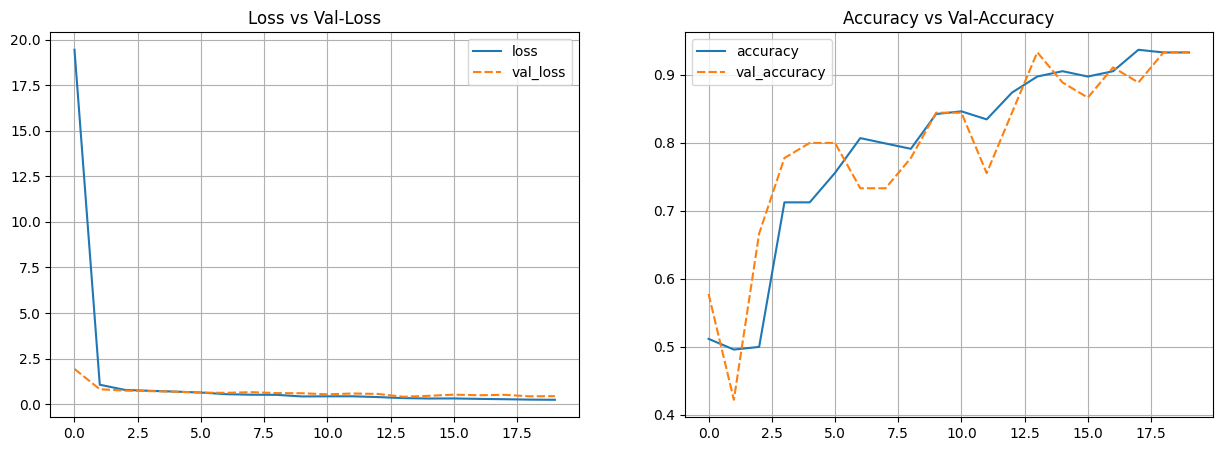

In [22]:
# Plot Training Results

history_seq_df1 = pd.DataFrame(history1.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_seq_df1[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_seq_df1[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')
plt.show()

Setelah menambahkan weight initializer dan dropout layer, kurva loss train dan validation set menunjukkan bahwa keduanya mencapai titik keseimbangan yang menunjukkan bahwa model berupa good fit. kurva akurasi dari train dan validation set pun menunjukkan bahwa keduanya akhirnya memiliki nilai akurasi yang sama.

In [23]:
test_results = model_imp.evaluate(test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.6679
Test Accuracy : 0.8491


# viii. Model Saving

In [24]:
# Model Summary
model_imp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,694,629 (216.27 MB)

 Trainable params: 18,898,209 (72.09 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 37,796,420 (144.18 MB)

In [25]:
# freeze model
model_imp.trainable = False
model_imp.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    18,874,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,694,629 (216.27 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,898,209 (72.09 MB)

 Optimizer params: 37,796,420 (144.18 MB)

In [27]:
import pickle

In [ ]:
with open ('imgen.pkl', 'wb') as file_1:
  pickle.dump(final_pipeline, file_1)

In [26]:
model_imp.save('model.keras')

# ix. Model Inference
Model inference dikerjakan pada notebook terlampir.

# x. Kesimpulan
1. Model ANN dapat digunakan untuk memprediksi gambar pekerja yang menggunakan helm atau tidak.
2. Model dasar menunjukkan terjadinya exploding gradient.
3. Penambahan weight initializer, L2 regularization, dan dropout layer bisa mengimprove model yang dibuat.
4. Model yang diimprove mengalami perbaikan pada prediksi test set dengan nilai akurasi sebesar 85%
